In [1]:
import collections
import pandas as pd
import os
import networkx as nx
import numpy as np
import tqdm.auto as tqdm
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import upsetplot

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "src")))
import utils

matplotlib.rcParams["axes.spines.right"] = False
matplotlib.rcParams["axes.spines.top"] = False

/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = "test_data"
methods_dict = {"clomics": "Clomics", "vcmtools": "VCMtools", "phm": "PHM"}
core_cm_path = "/data/pushkare/Chromatin_modules/1.mapped_CMs"

comparison_type = "compare_methods_per_cell_type"
core_path = os.path.join(
    "/data/pushkare/Chromatin_modules/6.compare_CMs", comparison_type
)
mean_type = "HM"

## Clomics parameters
n_peaks = "n_peaks_200"
bg_threshold = "bg_threshold_3"
## VCMtools parameters
vcm_window = "0.5Mb"
pv_threshold = "0.001"
## PHM parameter
pp_threshold = "0.8"

In [3]:
pairwise_means = []
for method_1, method_name_1 in methods_dict.items():
    for method_2, method_name_2 in methods_dict.items():
        path_to_dict = os.path.join(
            core_path,
            dataset,
            mean_type,
            mean_type + "_scores",
            "_".join([method_1, method_2, dataset, mean_type, "scores_dict.npy"]),
        )
        if os.path.exists(path_to_dict):
            scores_dict = np.load(path_to_dict, allow_pickle=True).item()
            mean_similarity = np.mean(list(scores_dict.values()))
            pairwise_means.append([method_1, method_2, mean_similarity])

In [4]:
similarity_edgelist = pd.DataFrame(
    pairwise_means, columns=["source", "target", "weight"]
)

adj_df = nx.to_pandas_adjacency(
    nx.from_pandas_edgelist(
        similarity_edgelist, source="source", target="target", edge_attr="weight"
    ),
    weight="weight",
)

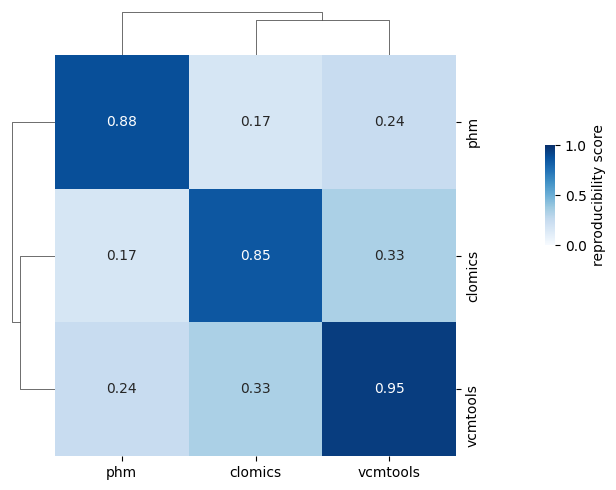

In [5]:
sns.clustermap(
    adj_df,
    cmap="Blues",
    vmin=0,
    vmax=1,
    figsize=(5, 5),
    annot=True,
    row_cluster=True,
    col_cluster=True,
    dendrogram_ratio=(0.1, 0.1),
    cbar_pos=(1.1, 0.5, 0.02, 0.2),
    fmt=".2",
    cbar_kws={
        "label": "reproducibility score",
    },
)
output_path = os.path.join(core_path, "plots")
if not os.path.exists(output_path):
    os.makedirs(output_path)
plt.savefig(
    os.path.join(
        output_path,
        "_".join(
            [
                dataset,
                "average",
                mean_type + "_scores",
                "per_method_heatmap.pdf",
            ]
        ),
    ),
    dpi=300,
    transparent=True,
    bbox_inches="tight",
)

### Get Venn diagrams for test_data

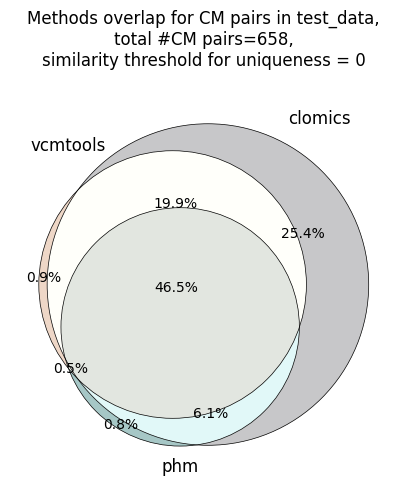

In [6]:
methods = list(methods_dict.keys())
threshold = 0
total_pairs = 0
cm_pairs_for_methods = {}
for i, method_1 in enumerate(methods):
    for method_2 in methods[i + 1 :]:
        path_to_dict = os.path.join(
            core_path,
            dataset,
            mean_type,
            mean_type + "_scores",
            "_".join([method_1, method_2, dataset, mean_type, "scores_dict.npy"]),
        )
        mthd_1_mthd_2_scores_dict = np.load(path_to_dict, allow_pickle=True).item()
        mthd_1_mthd_2_cm_sets = {
            "mthd_1_unique": set(),
            "mthd_2_unique": set(),
            "overlapping": set(),
            "mthd_1_specific_cms": set(),
            "mthd_2_specific_cms": set(),
        }
        for cm_pair, sim_score in mthd_1_mthd_2_scores_dict.items():
            cm_1, cm_2 = cm_pair.split("_")
            if (cm_1 != "NAN") and (cm_2 == "NAN"):
                mthd_1_mthd_2_cm_sets["mthd_1_unique"].update([cm_1])
            elif (cm_1 == "NAN") and (cm_2 != "NAN"):
                mthd_1_mthd_2_cm_sets["mthd_2_unique"].update([cm_2])
            elif sim_score <= threshold:
                mthd_1_mthd_2_cm_sets["mthd_1_unique"].update([cm_1])
                mthd_1_mthd_2_cm_sets["mthd_2_unique"].update([cm_2])
            elif sim_score > threshold:
                total_pairs += 1
                mthd_1_mthd_2_cm_sets["overlapping"].update([cm_pair])
                mthd_1_mthd_2_cm_sets["mthd_1_specific_cms"].update([cm_1])
                mthd_1_mthd_2_cm_sets["mthd_2_specific_cms"].update([cm_2])
        cm_pairs_for_methods[method_1 + "_" + method_2] = mthd_1_mthd_2_cm_sets

utils.get_sets_plot_venn(
    cm_pairs_for_methods, dataset, total_pairs, threshold, output_path
)

total n CM pairs 658


/home/pushkare/.local/lib/python3.11/site-packages/upsetplot/data.py:303: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/home/pushkare/.local/lib/python3.11/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace

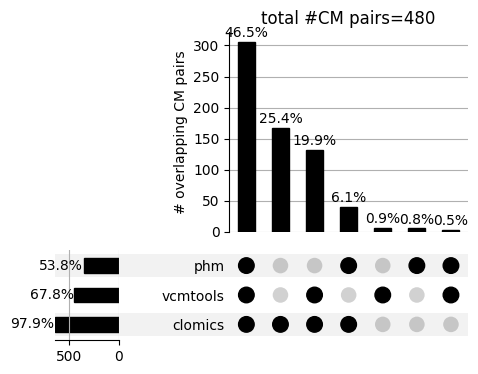

In [10]:
threshold = 0
total_pairs = 0
cm_pairs_for_methods = {}
for i, method_1 in enumerate(methods):
    for method_2 in methods[i + 1 :]:
        path_to_dict = os.path.join(
            core_path,
            dataset,
            mean_type,
            mean_type + "_scores",
            "_".join([method_1, method_2, dataset, mean_type, "scores_dict.npy"]),
        )
        mthd_1_mthd_2_scores_dict = np.load(path_to_dict, allow_pickle=True).item()
        mthd_1_mthd_2_cm_sets = {
            "mthd_1_unique": set(),
            "mthd_2_unique": set(),
            "overlapping": set(),
            "mthd_1_specific_cms": set(),
            "mthd_2_specific_cms": set(),
        }
        for cm_pair, sim_score in mthd_1_mthd_2_scores_dict.items():
            cm_1, cm_2 = cm_pair.split("_")
            if (cm_1 != "NAN") and (cm_2 == "NAN"):
                mthd_1_mthd_2_cm_sets["mthd_1_unique"].update([cm_1])
            elif (cm_1 == "NAN") and (cm_2 != "NAN"):
                mthd_1_mthd_2_cm_sets["mthd_2_unique"].update([cm_2])
            elif sim_score <= threshold:
                mthd_1_mthd_2_cm_sets["mthd_1_unique"].update([cm_1])
                mthd_1_mthd_2_cm_sets["mthd_2_unique"].update([cm_2])
            elif sim_score > threshold:
                total_pairs += 1
                mthd_1_mthd_2_cm_sets["overlapping"].update([cm_pair])
                mthd_1_mthd_2_cm_sets["mthd_1_specific_cms"].update([cm_1])
                mthd_1_mthd_2_cm_sets["mthd_2_specific_cms"].update([cm_2])
        cm_pairs_for_methods[method_1 + "_" + method_2] = mthd_1_mthd_2_cm_sets

cm_membership_df = utils.get_cm_membership_df(
    cm_pairs_for_methods,
    total_pairs,
)
fig = plt.figure(figsize=(8, 5))
ups = upsetplot.UpSet(
    cm_membership_df,
    subset_size="count",
    sort_by="cardinality",
    sort_categories_by="cardinality",
    with_lines=False,
    show_percentages=True,
).plot(fig=fig)
ups["intersections"].set_ylabel("# overlapping CM pairs")
plt.title("total #CM pairs=" + str(total_pairs))
plt.savefig(
    os.path.join(
        output_path,
        "_".join(
            [
                dataset,
                "similarity_threshold",
                str(threshold),
                "CM_overlaps_across_methods_all_marks_min_1bp_upset_plot.pdf",
            ]
        ),
    ),
    dpi=300,
    transparent=True,
    bbox_inches="tight",
)